### Imports

In [1]:
%load_ext autoreload
%autoreload complete

In [2]:
import string
import re
import nltk
import html2text
import html
from nltk.stem import WordNetLemmatizer
from lingua import Language, LanguageDetectorBuilder
from deep_translator import GoogleTranslator
import pandas as pd
from transformers import pipeline
from tqdm.auto import tqdm

In [3]:
tqdm.pandas()

In [23]:
IS_RTX4090 = True
BS = 128 if IS_RTX4090 else 1

### Tokenizing Text for Histogram and Word Cloud Analysis
To extract insight better, we remove useless stopwords and lemmatize the remaining words.

In [4]:
%%script echo skipping
df = pd.read_csv(
    "/home/jh2xl/Code/sch-repos/AIDS-Project-2/data/youtube_flex tape/announcement/Rjc7d1yS4Y0.csv"
).iloc[:10]

skipping


In [5]:
# Load all csvs in directory that can be concated.
from pathlib import Path

data_dir = Path("./data/youtube_flex tape")
paths = list(data_dir.glob("**/*.csv"))
df = pd.read_csv(paths[0])

for file in paths[1:]:
    print(file)
    try:
        df = pd.concat([df, pd.read_csv(file)], ignore_index=True)
    except Exception as e:
        print(f"Error reading {file}: {e}")

print(len(df))
df.head(5)

data/youtube_flex tape/review/QZfFJrthfQc.csv
data/youtube_flex tape/review/syCD0xBj3RA.csv
data/youtube_flex tape/unboxing/WzTukdL6NgM.csv
data/youtube_flex tape/unboxing/0xzN6FM5x_E.csv
data/youtube_flex tape/tutorial/cuXIGNvZYUU.csv
data/youtube_flex tape/tutorial/WzTukdL6NgM.csv
data/youtube_flex tape/tutorial/mQ3FSmBle3Q.csv
data/youtube_flex tape/comparison/aRXpfgik9XA.csv
data/youtube_flex tape/problems/hTYyO8aIhyc.csv
data/youtube_flex tape/announcement/vtH_-r89-9I.csv
data/youtube_flex tape/announcement/Rjc7d1yS4Y0.csv
14093


,id,videoId,parentId,isReply,authorName,authorId,text,likes,updatedAt
0,UgzCN0skLJC8BUWDfOh4AaABAg,WTYEi1iCNKI,UgzCN0skLJC8BUWDfOh4AaABAg,False,@AndrewDistelrath,UCsrlRNljbVQev4EXS84XFfA,"<a href=""https://www.youtube.com/watch?v=WTYEi...",0,2025-04-08T00:08:18Z
1,Ugx__arbeq9P3uQKPPl4AaABAg,EoBxYbhNZtQ,Ugx__arbeq9P3uQKPPl4AaABAg,False,@wolffire8819,UCfMPJ_6DpIx3Rl9TpAhrX1w,She flex on my caulk until I &quot;Phil Swift ...,0,2025-04-01T02:20:36Z
2,UgxBX9gqHVsRiImd01h4AaABAg,JIWgLmPF1m0,UgxBX9gqHVsRiImd01h4AaABAg,False,@BruceSepix,UC9Dp9A-XWedgNIRHEXIQfwg,I want to buy flex tape,0,2025-03-31T10:39:52Z
3,UgzO5O96acbYqWxrZMd4AaABAg,r_VCjE49Hu4,UgzO5O96acbYqWxrZMd4AaABAg,False,@gh0stf4c38,UCXwf72SLQ2INakJQoLpY9AA,what about if we got flex packing tape or flex...,0,2025-03-30T21:22:44Z
4,UgzABTcUUoTje8I3Qix4AaABAg,DuEUt7UNVO4,UgzABTcUUoTje8I3Qix4AaABAg,False,@RedCobra_QC,UCN4waN5Uzm78Xie01nHSCNg,Flex Tape Wide Boat,0,2025-03-25T16:59:51Z


In [6]:
h = html2text.HTML2Text()
h.ignore_links = True
h.ignore_mailto_links = True
h.ignore_images = True
h.ignore_emphasis = True
h.ignore_tables = True

# Normalize from HTML back to text.
def html_to_text(text):
    text = h.handle(text)
    text = html.unescape(text)
    return text.strip()

In [7]:
detector = (
    LanguageDetectorBuilder.from_all_languages()
    .with_preloaded_language_models()
    .build()
)


# Translate to English if not already in English.
def translate_row(lang_col="lang", text_col="text", trans_col="translated"):
    def _inner(row):
        if row[lang_col] is None:
            sent = None
        elif row[lang_col] != Language.ENGLISH.name:
            sent = GoogleTranslator(source="auto", target="en").translate(row["text"])
        else:
            sent = row[text_col]
        row[trans_col] = "" if sent is None else sent.strip()
        return row

    return _inner

In [8]:
num_re = r"\b\d+\b"
spaces_re = r"\s+"
product_name = r"\bflex tape\b"

nltk.download("stopwords")
nltk.download("wordnet")

stopwords = nltk.corpus.stopwords.words("english")
punc_translate = str.maketrans(string.punctuation, " " * len(string.punctuation))
wnl = WordNetLemmatizer()

# TODO: Have a version that maintains original structure for ye olde sentiment analysis.
def tokenize(text):
    # Remove numbers
    text = re.sub(num_re, " ", text)
    # Remove punctuation
    text = text.translate(punc_translate)
    # Remove extra spaces
    text = re.sub(spaces_re, " ", text)
    text = text.strip()

    # Lowercase
    text = text.lower()

    # Remove certain words, like the product name itself.
    # Or also normalize names to their full form: i.e., obama -> barack obama
    text = re.sub(product_name, " ", text)

    # Remove extra spaces again.
    text = re.sub(spaces_re, " ", text)
    text = text.strip()

    # TODO: Do NER and other techniques to preserve hyphenated words and nouns.
    # Remove stopwords
    tokens = text.split()
    tokens = [t for t in tokens if t not in stopwords]

    # Lemmatize
    tokens = [wnl.lemmatize(t) for t in tokens]

    # Filter empty and short tokens
    tokens = [t for t in tokens if len(t) > 2]
    return tokens


[nltk_data] Downloading package stopwords to /home/jh/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /home/jh/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [ ]:
# Sentiment analysis. Its multilingual!
sentiment_classifier = pipeline(
    "sentiment-analysis",
    model="tabularisai/multilingual-sentiment-analysis",
)

def classify_sentiment(texts):
    texts = [text.strip() for text in texts]
    results = sentiment_classifier(texts, truncation=True, batch_size=BS)
    lbls = [result["label"] for result in results]
    return lbls

classify_sentiment(["Thank you for a great 2019, Flex Fans! You truly are the best and inspire us to keep building a bigger and better Flex World. TO THE FLEX COMMUNITY! 💪🔛"*500])

Device set to use cuda:0


['Very Positive']

In [ ]:
topics = [
    "comment on aesthetics",
    "comment on functionality",
    "comment on durability",
    "comment on ease of use",
    "comment on price",
    "miscellaneous comment",
]

topic_classifier = pipeline(
    "zero-shot-classification", model="cross-encoder/nli-deberta-v3-large"
)

def classify_topic(texts):
    texts = [text.strip() for text in texts]
    results = topic_classifier(texts, candidate_labels=topics, truncation=True, batch_size=BS)
    lbls = []
    for result in results:
        lbl = sorted(list(zip(result["scores"], result["labels"])), reverse=True)[0][1]
        lbls.append(lbl)
    return lbls


classify_topic(["This product is very durable and easy to use."])

Device set to use cuda:0


['comment on durability']

In [11]:
# Get chunked indices for DF.
def chunk_indices(n, chunk_size):
    slices = []
    for i in range(0, n, chunk_size):
        slices.append(slice(i, min(i + chunk_size, n)))
    return slices

def chunk_array(arr, chunk_size):
    n = len(arr)
    slices = chunk_indices(n, chunk_size)
    chunks = []
    for s in slices:
        chunks.append(arr[s])
    return chunks

def chunk_apply(arr, func, chunk_size=16, *args, **kwargs):
    chunks = chunk_array(arr, chunk_size)
    results = []
    for chunk in tqdm(chunks):
        result = func(chunk, *args, **kwargs)
        results.extend(result)
    return results

In [ ]:
# Convert html back to text.
df["text"] = df["text"].progress_apply(html_to_text)

# Detect all langs.
df["lang"] = [None if l is None else l.name for l in detector.detect_languages_in_parallel_of(df["text"])]

# Translate non-English rows.
# Google blocked me.
# df = df.progress_apply(translate_row(lang_col="lang", text_col="text", trans_col="translated"), axis=1)

# Classify all sentiments using non-translated text (since model is multilingual and emoji robust).
df["sentiment"] = chunk_apply(df["text"], classify_sentiment, chunk_size=BS)

# Apply topic classification to translated text.
# df["topic"] = chunk_apply(df["translated"], classify_topic, chunk_size=BS)
df["topic"] = chunk_apply(df["text"], classify_topic, chunk_size=BS)

# Tokenize all words.
# df["tokenized"] = df["translated"].apply(tokenize)
df["tokenized"] = df["text"].progress_apply(tokenize)

df.sample(1)

  0%|          | 0/14093 [00:00<?, ?it/s]

  0%|          | 0/111 [00:00<?, ?it/s]

You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset


  0%|          | 0/111 [00:00<?, ?it/s]

  0%|          | 0/14093 [00:00<?, ?it/s]

,id,videoId,parentId,isReply,authorName,authorId,text,likes,updatedAt,lang,sentiment,topic,tokenized
8784,Ugy4s_dSyiyWA8MYU2h4AaABAg.8wvG1t2GfkI8wvgb5KJyl6,aRXpfgik9XA,Ugy4s_dSyiyWA8MYU2h4AaABAg,True,@ProjectFarm,UC2rzsm1Qi6N1X-wuOg_p0Ng,Thank you!,0,2019-07-03T13:17:52Z,ENGLISH,Positive,comment on price,[thank]


In [18]:
df.sample(10).drop(columns=["id", "videoId", "parentId", "authorId", "tokenized", "lang", "updatedAt"], axis=1)

,isReply,authorName,text,likes,sentiment,topic
820,False,@chinnawatgaewnuch2997,Bro did the flex tape is real? Becuase Preston...,0,Neutral,comment on durability
6017,False,@sondash,meme,0,Negative,comment on aesthetics
3541,False,@JDeb71024,Let's see it work on a pipe that under pressur...,0,Neutral,comment on functionality
3227,False,@shelialittlejohn5960,I’d like to see a video on the spray white fle...,0,Positive,comment on functionality
8659,False,@benoit.gerin-lajoie,Don't forget to add a price comparison chart p...,0,Neutral,comment on price
6364,False,@elChirrinChirriondelDiablo,I was actually waiting for a fail,0,Very Negative,comment on functionality
5495,False,@bigpapicarwash4015,fake not work👎🏻,0,Negative,comment on functionality
9789,True,@chall-us6de,Quarters,0,Neutral,comment on price
8147,False,@sohailmahboob3760,"Very informative, easy to understand terms and...",0,Very Positive,comment on ease of use
9690,False,@TylerStrandlie,You did the flex tap wrong,0,Very Negative,comment on functionality


In [13]:
df.to_pickle("test.pkl.xz")

(np.float64(-0.5), np.float64(799.5), np.float64(399.5), np.float64(-0.5))

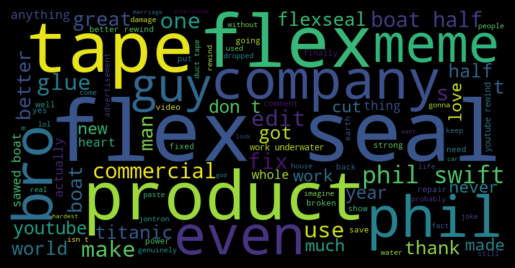

In [21]:
# Chain tokenized words across all rows into a single string for word cloud.
from wordcloud import WordCloud
from itertools import chain
import matplotlib.pyplot as plt

# Prefilters.
df2 = df
df2 = df2[~df2.isReply]  # Filter by if comment is reply.
df2 = df2[df2.likes > 100]  # Filter by likes.
df2 = df2[df2.text.str.len() > 20]  # Filter by text length.
# TODO: date filtering.
# df2 = df2[df2.updatedAt > "TODO"]  # Filter by JS-style date e.g., 2020-01-31T17:01:46Z
# TODO: compound/weighted filtering.

all_words = list(chain.from_iterable(df2["tokenized"].tolist()))
# NOTE: It supports collocations by default; so it will try and guess bigrams on its own.
# https://amueller.github.io/word_cloud/generated/wordcloud.WordCloud.html
wordcloud = WordCloud(
    width=800,
    height=400,
    max_words=100,
    mode="RGBA",
).generate("\t".join(all_words))


plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")

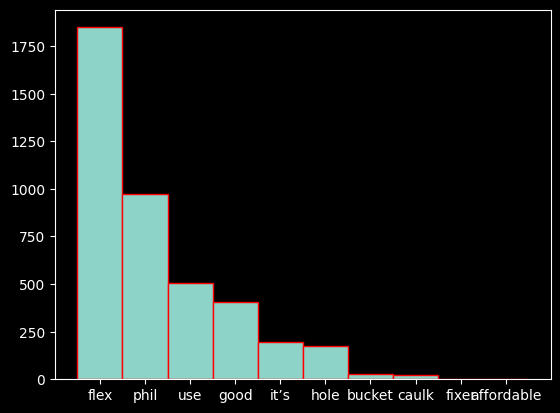

In [20]:
from collections import Counter
import numpy as np
import matplotlib.pyplot as plt
from nltk.util import everygrams

# Prefilters.
df2 = df
df2 = df2[~df2.isReply]  # Filter by if comment is reply.
df2 = df2[df2.likes > 100]  # Filter by likes.
df2 = df2[df2.text.str.len() > 20]  # Filter by text length.
# TODO: date filtering.
# df2 = df2[df2.updatedAt > "TODO"]  # Filter by JS-style date e.g., 2020-01-31T17:01:46Z
# TODO: compound/weighted filtering.

max_lbl_len = 16
top_n = 10
n_gram = 1

freqs = Counter(
    [
        " ".join(s)
        for s in everygrams(
            chain.from_iterable(df["tokenized"].tolist()), max_len=n_gram
        )
    ]
)
lbls, vals = zip(*freqs.items())

# Drop irrelevant words.

# Take top n words.
if len(lbls) > top_n:
    lbls = lbls[:top_n]
    vals = vals[:top_n]

# rearrange your data.
sort_idx = np.argsort(vals)[::-1]
lbls = np.array(lbls)[sort_idx]
vals = np.array(vals)[sort_idx]

# Trim really long labels with ellipses.
lbls = [l[: max_lbl_len - 3] + "..." if len(l) > max_lbl_len else l for l in lbls]

indexes = np.arange(len(lbls))
plt.bar(indexes, vals, width=1.0, edgecolor="red")
plt.xticks(indexes, lbls)
plt.show()